In [1]:
using Agents, Plots, LightGraphs, GraphRecipes, MetaGraphs, Random
include("src/warehouse.jl")
include("src/a_star_cbs.jl")

LoadError: LoadError: ArgumentError: Package DataStructures not found in current path:
- Run `import Pkg; Pkg.add("DataStructures")` to install the DataStructures package.

in expression starting at /home/datalab/projects/agents/warehouse/src/a_star_cbs.jl:4

terminate_warehouse_sim (generic function with 1 method)

main (generic function with 1 method)

# Init Warehouse

In [118]:
adjacency_matrix(g)

35×35 SparseArrays.SparseMatrixCSC{Int64, Int64} with 68 stored entries:
⠪⡢⡈⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠂⡈⠀⠀⠈⠂⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠢⠀⠀⡠⡀⠢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠠⡈⠪⠂⠈⠠⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠂⡀⠀⠀⠀⠂⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠠⠀⠪⡢⡈⠠⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠂⡈⠀⠀⠈⠂⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠢⠀⠀⡠⡀⠂
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠠⠈⠪⠂

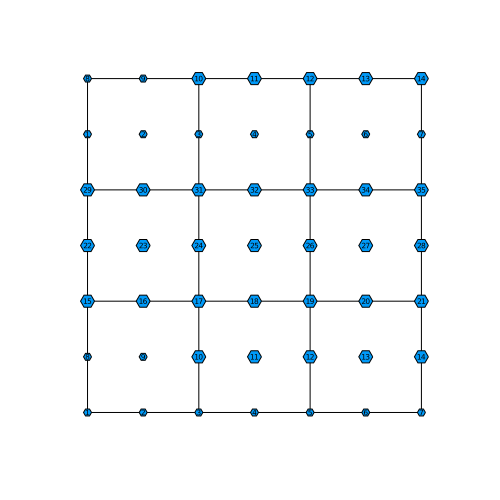

In [284]:
m,n = 3,3
g,p,d = generate_warehouse_struct(m,n,d_start=2,graph_type=SimpleGraph)
graphplot(Matrix(adjacency_matrix(g)),x=p[:,2],y=p[:,1],size=(500,500),curves=false,names=1:nv(w),fontsize=5)

In [303]:
function init_warehouse()
    Random.seed!(1234)

    ## Simulation 
    n_packages = 10
    load_spots = [8,12]
    package_list = rand(1:length(d),n_packages);

    warehouse_space = GraphSpace(g)
    model_props = Dict(:package_list=>package_list,
    :load_spot=>load_spots,
    :last_spot=> length(load_spots),
    :dest_spot=>d,
    :graph => g,
    :step => 1,
    :check_next_step => true,
    :used_load_spots=>zeros(Int,(length(load_spots))))

    warehouse = ABM(Robot, warehouse_space;properties= model_props)

    add_agent!(Robot(1,2,0,1,[]),2, warehouse)
    add_agent!(Robot(2,6,0,1,[]),6, warehouse)
    return warehouse, model_props
end

init_warehouse (generic function with 1 method)

In [300]:
model_props[:load_spot]

2-element Vector{Int64}:
  8
 12

In [304]:
warehouse,model_props = init_warehouse()
dest_spot_grid = model_props[:dest_spot].-(2*n+1)

robot_colors = (x,y)-> robot_colors_spots(x,y,model_props[:load_spot],dest_spot_grid)
robot_sizes = (x,y,z) -> robot_sizes_spots(x,y,z,model_props[:load_spot],model_props[:dest_spot],dest_spot_grid,factor)

cs=fill(0.05, nv(g), nv(g));

plot_warehouse = ()-> plotabm(warehouse;am=(x,y)->:rect,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,curvature_scalar=cs,size=(750,750),linealpha=0.5,markerstrokewidth=0.0)

#291 (generic function with 1 method)

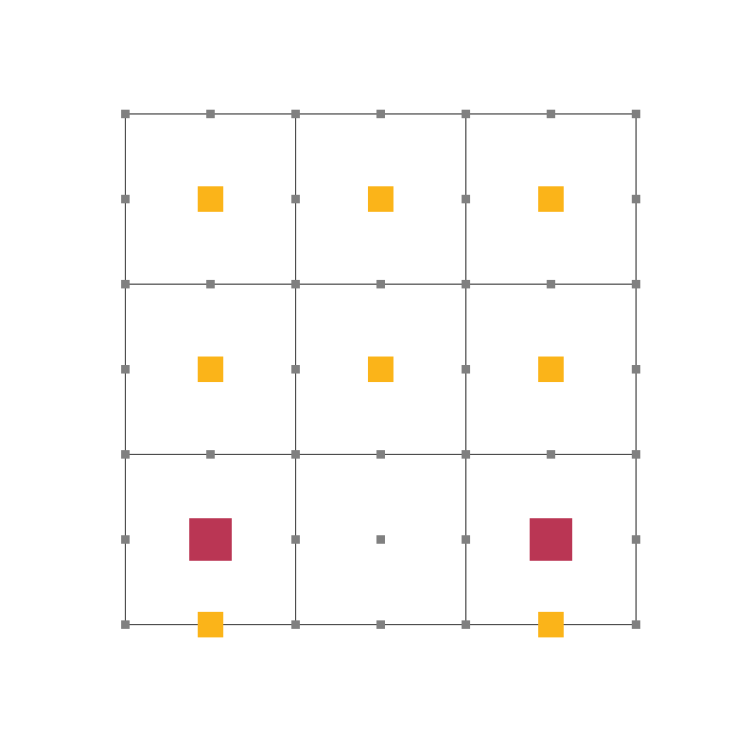

In [305]:
plot_warehouse()

In [250]:
adata = [:pos, :dest,:head]
data, _ = run!(warehouse, robot_step!,warehouse_step!,terminate_warehouse_sim; adata)

LoadError: InterruptException:

## CBS Warehouse Step

In [228]:
function warehouse_step!(model)

    replan = false
    
    #TODO collision test
    
    for robot in allagents(model)
#         display(robot)
        if robot.dest == 0
            replan = true
            if robot.pos in model.load_spot && !isempty(model.package_list)# nalozeni
                next_package_dest = popfirst!(model.package_list)
                robot.dest = model.dest_spot[next_package_dest]
            elseif robot.pos in model.dest_spot || model.step == 1 #vylozeni
                robot.dest = get_load_spot(model)                
            end                                                                        
        end
#         display(robot)
    end
    
    if replan
         
        et = edgetype(model.graph)
        n_agents = nagents(model)

        constraints = init_constraints(n_agents,et)
        paths = [a_star(model.graph, robot.pos,robot.dest) for robot in [getindex(model,idx) for idx in 1:n_agents]]
        root= CBSNode(constraints,paths,length.(paths))

        solution = cbs(root,model.graph)
        for i in 1:n_agents
            robot = getindex(model,i)
            robot.path = solution[i]
        end
#         display(solution)

    end
    
    model.step += 1
end;

In [180]:
function robot_step!(robot,model)    
    if !isempty(robot.path)        
        next_step = robot.path[1].dst
        move_agent!(robot,next_step,model)
        popfirst!(robot.path)
    end
    
    if robot.dest == robot.pos || robot.pos in model.load_spot
        robot.dest = 0        
    end
end;

In [178]:
robots = collect(allagents(warehouse))

2-element Vector{Robot}:
 Robot(2, 21, 32, 1, LightGraphs.SimpleGraphs.SimpleEdge{Int64}[Edge 21 => 26, Edge 26 => 31, Edge 31 => 32])
 Robot(1, 24, 0, 1, LightGraphs.SimpleGraphs.SimpleEdge{Int64}[])

In [308]:
warehouse,_ = init_warehouse()

(AgentBasedModel with 2 agents of type Robot
 space: GraphSpace with 49 positions and 48 edges
 scheduler: fastest
 properties: Dict{Symbol, Any}(:load_spot => [8, 12], :graph => {49, 48} undirected simple Int64 graph, :last_spot => 2, :step => 1, :used_load_spots => [0, 0], :package_list => [3, 4, 6, 4, 1, 3, 6, 1, 1, 5], :dest_spot => [30, 32, 34, 44, 46, 48], :check_next_step => true), Dict{Symbol, Any}(:load_spot => [8, 12], :graph => {49, 48} undirected simple Int64 graph, :last_spot => 2, :step => 1, :used_load_spots => [0, 0], :package_list => [3, 4, 6, 4, 1, 3, 6, 1, 1, 5], :dest_spot => [30, 32, 34, 44, 46, 48], :check_next_step => true))

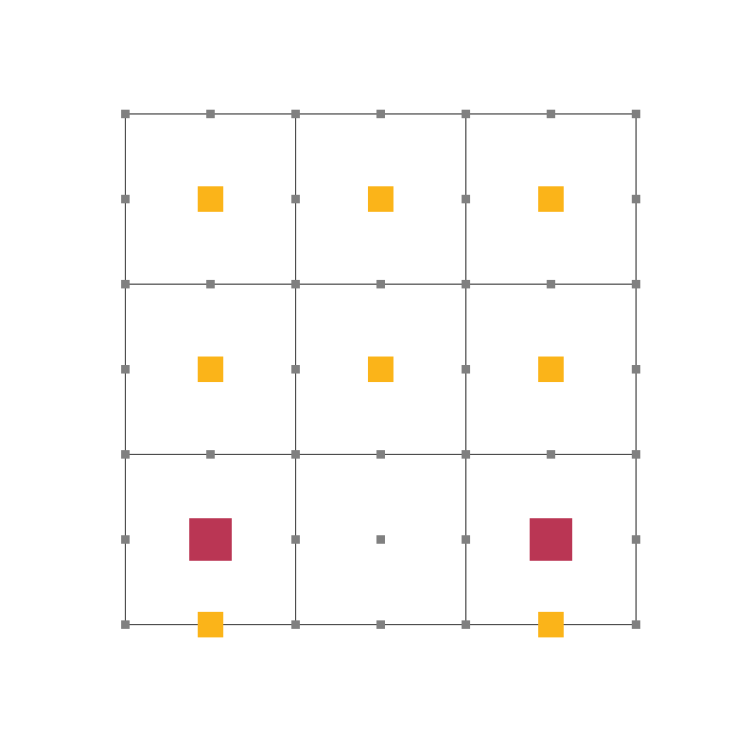

In [309]:
plot_warehouse()

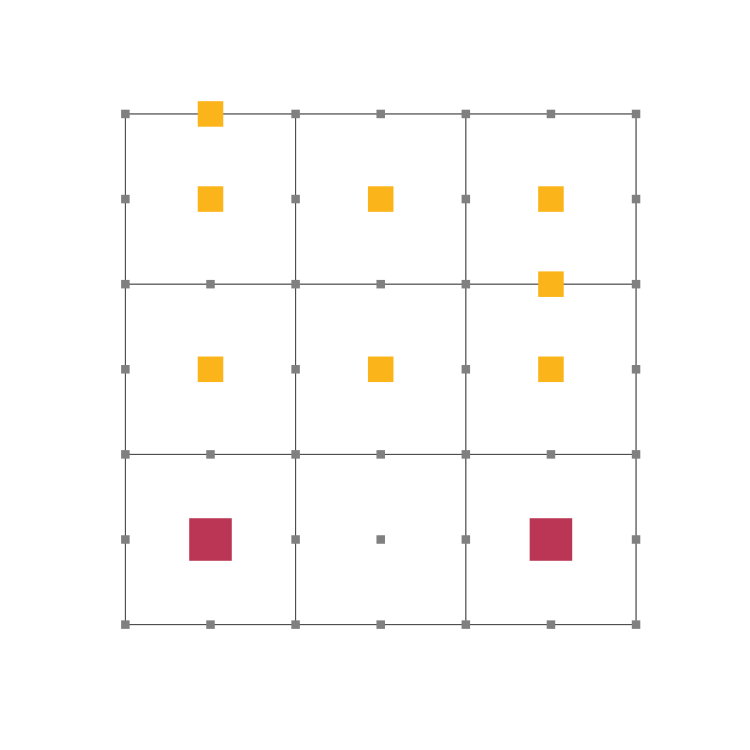

In [323]:
step!(warehouse, robot_step!,warehouse_step!, 1,false)                    
plot_warehouse()

In [329]:
warehouse.step

320740

In [328]:
warehouse,_ = init_warehouse()
# adata = [:pos, :dest,:head]
data, _ = run!(warehouse, robot_step!,warehouse_step!,terminate_warehouse_sim; agents_first=false)
warehouse.step

LoadError: InterruptException:

In [331]:
warehouse,_ = init_warehouse()
display(warehouse.properties)
anim = @animate for i in 0:80
    # p1 = plotabm(warehouse;am=(x,y)->:circle,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,arrow=true,curvature_scalar=cs,size=(1000,1000))
#     p1 = plotabm(warehouse;am=(x,y)->:rect,as=robot_sizes,ac=robot_colors,x=p[:,2],y=p[:,1],curves=false,arrow=false,curvature_scalar=cs,size=(2000,2000),linealpha=0.5,markerstrokewidth=0.0)
    p1 = plot_warehouse()
    display(i)    
    title!(p1, "step:$(i),packages to dispatch:$(length(warehouse.properties[:package_list]))")
    if terminate_warehouse_sim(warehouse,i)
        # gif(anim, "warehouse_$(m)_$(n)_$(n_agents).mp4", fps = 4)
        break
    end
    step!(warehouse, robot_step!,warehouse_step!, 1,false)
end
gif(anim, "cbs_warehouse_$(m)_$(n)_$(n_agents).mp4", fps = 4);

Dict{Symbol, Any} with 8 entries:
  :load_spot       => [8, 12]
  :graph           => {49, 48} undirected simple Int64 graph
  :last_spot       => 2
  :step            => 1
  :used_load_spots => [0, 0]
  :package_list    => [3, 4, 6, 4, 1, 3, 6, 1, 1, 5]
  :dest_spot       => [30, 32, 34, 44, 46, 48]
  :check_next_step => true

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

┌ Info: Saved animation to 
│   fn = /home/vojta/data/agents/warehouse2/cbs_warehouse_3_3_2.mp4
└ @ Plots /home/vojta/.julia/packages/Plots/oZheM/src/animation.jl:104
